# Part III: Modelling

## Content:
1. Basic settings
2. Split train and validation data for timeseries
3. Simple model
4. Features selection
5. Better model

## 1. Basic settings

In [1]:
# Basic libs
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from tqdm import tqdm

# pandas options
pd.options.display.max_columns = 20
pd.options.display.max_rows = 150

In [2]:
SALES_DATA_PATH = Path("../data/preprocessed-data/sales_data_preprocessed.csv")
# FEATURES_DATA_PATH = Path("../data/preprocessed-data/data_additional_featues.feather")
num_features = 45
FEATURES_DATA_PATH = Path(f"../data/preprocessed-data/data_additional_{num_features}_features.feather")
df_sales = pd.read_csv(SALES_DATA_PATH, parse_dates=["date"])
df_features = pd.read_feather(FEATURES_DATA_PATH)

In [3]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365500 entries, 0 to 365499
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    365500 non-null  datetime64[ns]
 1   store   365500 non-null  int64         
 2   item    365500 non-null  int64         
 3   sales   365500 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 11.2 MB


In [4]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365500 entries, 0 to 365499
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       365500 non-null  datetime64[ns]
 1   store                      365500 non-null  int64         
 2   item                       365500 non-null  int64         
 3   sales                      365500 non-null  float64       
 4   last_1_days_sales          365000 non-null  float64       
 5   last_7_days_sales          362000 non-null  float64       
 6   last_14_days_sales         358500 non-null  float64       
 7   last_21_days_sales         355000 non-null  float64       
 8   last_28_days_sales         351500 non-null  float64       
 9   last_90_days_sales         320500 non-null  float64       
 10  last_180_days_sales        275500 non-null  float64       
 11  recent_7_days_mean_sales   362500 non-null  float64 

## 2. Split train and validation data for ts

In [5]:
def split_time_series_data(df, target_col="sales", date_col="date", split_date=None):
    """
    Split time series data into training and validation sets based on a specified date.

    Parameters:
    - df (pd.DataFrame): The time series DataFrame sorted by date.
    - target_col (str): The name of the target variable. Default is "sales".
    - date_col (str): The name of the date column. Default is "date".
    - split_date (str): The date used to split the data into training and validation sets.

    Returns:
    - pd.DataFrame, pd.Series, pd.DataFrame, pd.Series: X_train, y_train, X_val, y_val

    Example:
    ```python
    # Assuming df_preprocessed is the time series DataFrame
    X_train, y_train, X_val, y_val = split_time_series_data(df_preprocessed, split_date='2017-10-01')
    ```

    Note:
    - Make sure that the DataFrame is sorted by date before using this function.
    """
    # Ensure the DataFrame is sorted by date
    df_sorted = df.sort_values(date_col).reset_index(drop=True)

    # Train-Validation Split
    train_set = df_sorted.loc[df_sorted[date_col] < split_date, :]
    val_set = df_sorted.loc[
        (df_sorted[date_col] >= split_date)
        & (df_sorted[date_col] <= df_sorted[date_col].max()),
        :,
    ]

    # Extract features and target variables
    feature_cols = [
        col for col in df_sorted.columns if col not in [date_col, target_col]
    ]

    X_train = train_set[feature_cols]
    X_val = val_set[feature_cols]
    y_val = val_set[target_col]
    y_train = train_set[target_col]

    return X_train, X_val, y_train, y_val

In [6]:
X_train, X_val, y_train, y_val = split_time_series_data(
    df_features, split_date="2017-10-01"
)

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((319500, 43), (319500,), (46000, 43), (46000,))

## 3. Simple model

### 3.1. Define the custom evaluation function for SMAPE

In [8]:
def symmetric_mean_absolute_percentage_error(predictions, targets):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
    - predictions: Predicted values.
    - targets: Actual target values.

    Returns:
    - SMAPE value.
    """
    non_zero_mask = ~((predictions == 0) & (targets == 0))
    predictions, targets = predictions[non_zero_mask], targets[non_zero_mask]

    absolute_errors = np.abs(predictions - targets)
    absolute_sum = np.abs(predictions) + np.abs(targets)

    smape_value = 200 * np.mean(absolute_errors / absolute_sum)
    return smape_value

In [9]:
# Sample check
predictions = np.array([20, 30, 40, 50])
targets = np.array([25, 35, 45, 55])

# Calculate SMAPE
smape_value = symmetric_mean_absolute_percentage_error(predictions, targets)

# Print the results
print("Predictions:", predictions)
print("Targets:", targets)
print("SMAPE:", smape_value)

Predictions: [20 30 40 50]
Targets: [25 35 45 55]
SMAPE: 14.723838253250019


In [10]:
def lgbm_smape_evaluation(y_true, y_pred):
    """
    LightGBM custom evaluation function for SMAPE.

    Parameters:
    - y_true: Actual target values.
    - y_pred: Predicted values.

    Returns:
    - Tuple containing evaluation metric name, SMAPE value
    """
    smape_value = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return smape_value

### 3.2. Train a simple model

In [11]:
def train_and_evaluate_lgbm(
    X_train, y_train, X_val, y_val, custom_metric, model_params=None
):
    """
    Create, train, and evaluate the LightGBM regression model with the custom evaluation metric.

    Parameters:
    - X_train, Y_train: Training data and target.
    - X_val, Y_val: Validation data and target.
    - custom_metric: Custom evaluation metric function.
    - model_params: Optional parameters for the LightGBM model.

    Returns:
    - Trained LightGBM model.
    """
    if model_params is None:
        model_params = {"random_state": 42}

    # Create and train a LightGBM model
    lgb_model = lgb.LGBMRegressor(**model_params)
    lgb_model.fit(X_train, y_train, eval_metric=custom_metric)

    # Evaluate and print SMAPE on the training set
    train_smape = custom_metric(y_train, lgb_model.predict(X_train))
    print("TRAIN SMAPE:", train_smape)

    # Evaluate and print SMAPE on the validation set
    valid_smape = custom_metric(y_val, lgb_model.predict(X_val))
    print("VALID SMAPE:", valid_smape)

    return lgb_model


In [12]:
# Training
simple_model = train_and_evaluate_lgbm(
    X_train, y_train, X_val, y_val, custom_metric=lgbm_smape_evaluation
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8751
[LightGBM] [Info] Number of data points in the train set: 319500, number of used features: 43
[LightGBM] [Info] Start training from score 58.124626
TRAIN SMAPE: 12.957190942092497
VALID SMAPE: 14.1629061549606


### 3.3. Visualize the importances of features

In [13]:
def get_lgb_importances(model, num=10):
    gain = model.booster_.feature_importance(importance_type="gain")
    feat_imp = pd.DataFrame(
        {
            "feature": model.feature_name_,
            "split": model.booster_.feature_importance(importance_type="split"),
            "gain": 100 * gain / gain.sum(),
        }
    ).sort_values("gain", ascending=False)

    return feat_imp.head(num)


def show_importance_plot(feature_imp_df, figsize=(8, 6)):
    sns.set(font_scale=1)
    plt.figure(figsize=figsize)
    sns.barplot(x="gain", y="feature", data=feature_imp_df, color="r")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [14]:
get_lgb_importances(simple_model, num=30)

,feature,split,gain
9,recent_7_days_mean_sales,377,85.358763
3,last_7_days_sales,148,5.831220
4,last_14_days_sales,138,3.136688
5,last_21_days_sales,157,1.396367
6,last_28_days_sales,178,1.148016
2,last_1_days_sales,285,0.908476
10,recent_7_days_min_sales,146,0.384752
11,recent_7_day_max_sales,110,0.273957
42,humidity,260,0.224539
12,recent_7_day_std_sales,201,0.224149


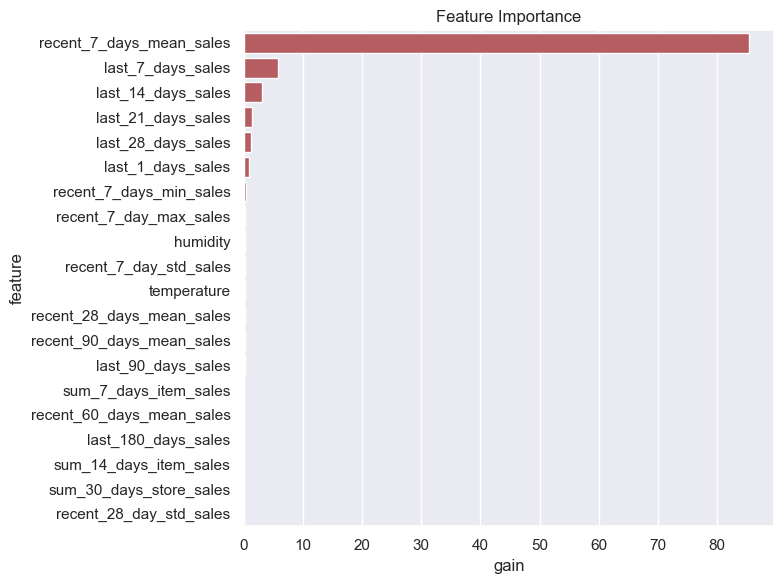

In [15]:
show_importance_plot(get_lgb_importances(simple_model, num=20))

## 4. Features selection

In [16]:
# pass

## 5. Parameter tuning

In [17]:
# !pip install optuna --quiet

In [18]:
import optuna


def objective(trial, df, custom_metric):
    """
    Objective function for Optuna optimization.

    Parameters:
    - trial: Optuna Trial object.
    - X: Training data.
    - y: Target variable.
    - custom_metric: Custom evaluation metric function.

    Returns:
    - SMAPE value to minimize.
    """
    # Split the data for training and validation
    X_train, X_val, y_train, y_val = split_time_series_data(df, split_date="2017-10-01")

    # Define hyperparameters to optimize
    params = {
        "objective": "regression",
        "metric": "custom",
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["gbdt", "dart", "goss"]
        ),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1),
    }

    # Exclude bagging parameters when boosting_type is 'goss'
    if params["boosting_type"] != "goss":
        params["bagging_fraction"] = trial.suggest_float("bagging_fraction", 0.1, 1)
        params["bagging_freq"] = trial.suggest_int("bagging_freq", 1, 10)

    # Create and train LightGBM model
    lgb_model = lgb.LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train, eval_metric=custom_metric)

    # Evaluate using the validation set and return the SMAPE
    val_smape = custom_metric(y_val, lgb_model.predict(X_val))
    return val_smape

In [19]:
def optimize_lightgbm(X, y, custom_metric, n_trials=50):
    study = optuna.create_study(direction="minimize")
    objective_fn = lambda trial: objective(trial, df_features, custom_metric)

    # Optimize the objective function
    study.optimize(objective_fn, n_trials=n_trials)

    # Print study trials and statuses
    for trial in study.trials:
        print(f"Trial #{trial.number}, Status: {trial.state}, Value: {trial.value}")

    if len(study.trials) == 0 or all(
        trial.state == optuna.trial.TrialState.FAIL for trial in study.trials
    ):
        raise ValueError("No successful trials have been completed.")

    # Get the best hyperparameters
    best_params = study.best_params

    return best_params

In [20]:
# Example usage:
best_params = optimize_lightgbm(
    X_train, y_train, custom_metric=lgbm_smape_evaluation, n_trials=30
)

[I 2024-01-13 06:59:39,130] A new study created in memory with name: no-name-64129f52-792a-4c1c-81b3-8efdb76da6fb


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.24169617936342563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24169617936342563
[LightGBM] [Warning] bagging_fraction is set=0.7563534729980501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563534729980501
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.24169617936342563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24169617936342563
[LightGBM] [Warning] bagging_fraction is set=0.7563534729980501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563534729980501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[I 2024-01-13 06:59:44,523] Trial 0 finished with value: 21.850527845514513 and parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'learning_rate': 0.04974326917545018, 'feature_fraction': 0.24169617936342563, 'bagging_fraction': 0.7563534729980501, 'bagging_freq': 2}. Best is trial 0 with value: 21.850527845514513.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.24169617936342563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24169617936342563
[LightGBM] [Warning] bagging_fraction is set=0.7563534729980501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563534729980501
[LightGBM] [Warning] feature_fraction is set=0.5497472637080396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5497472637080396
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5497472637080396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5497472637080396
[LightGBM] [Warning] Found boosting=goss. For backwards compatibilit

[I 2024-01-13 06:59:48,388] Trial 1 finished with value: 14.085554621221782 and parameters: {'boosting_type': 'goss', 'num_leaves': 85, 'learning_rate': 0.05437584082273989, 'feature_fraction': 0.5497472637080396}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] feature_fraction is set=0.5497472637080396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5497472637080396
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.44817980456564865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44817980456564865
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.44817980456564865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44817980456564865
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as b

[I 2024-01-13 06:59:51,635] Trial 2 finished with value: 15.010899378811985 and parameters: {'boosting_type': 'goss', 'num_leaves': 67, 'learning_rate': 0.03284599340379387, 'feature_fraction': 0.44817980456564865}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] feature_fraction is set=0.44817980456564865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44817980456564865
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.34945402300835965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34945402300835965
[LightGBM] [Warning] bagging_fraction is set=0.22105056134924325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22105056134924325
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.34945402300835965, colsample_bytree=1.0 will be ignored. Curren

[I 2024-01-13 06:59:55,928] Trial 3 finished with value: 37.74718362990364 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'learning_rate': 0.011872880398029174, 'feature_fraction': 0.34945402300835965, 'bagging_fraction': 0.22105056134924325, 'bagging_freq': 6}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.34945402300835965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34945402300835965
[LightGBM] [Warning] bagging_fraction is set=0.22105056134924325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22105056134924325
[LightGBM] [Warning] feature_fraction is set=0.19891332884777774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19891332884777774
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.19891332884777774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19891332884777774
[LightGBM] [Warning] Found boosting=goss. For backwards compat

[I 2024-01-13 06:59:59,324] Trial 4 finished with value: 14.405464364714199 and parameters: {'boosting_type': 'goss', 'num_leaves': 78, 'learning_rate': 0.08010641613862744, 'feature_fraction': 0.19891332884777774}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] feature_fraction is set=0.19891332884777774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19891332884777774
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8237690961488254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8237690961488254
[LightGBM] [Warning] bagging_fraction is set=0.31143919438615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31143919438615
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8237690961488254, colsample_bytree=1.0 will be ignored. Current value: 

[I 2024-01-13 07:00:04,837] Trial 5 finished with value: 31.03046672797019 and parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'learning_rate': 0.02216333308549838, 'feature_fraction': 0.8237690961488254, 'bagging_fraction': 0.31143919438615, 'bagging_freq': 2}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8237690961488254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8237690961488254
[LightGBM] [Warning] bagging_fraction is set=0.31143919438615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31143919438615
[LightGBM] [Warning] feature_fraction is set=0.20181259280023062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20181259280023062
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.20181259280023062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20181259280023062
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility 

[I 2024-01-13 07:00:07,768] Trial 6 finished with value: 14.43198495745078 and parameters: {'boosting_type': 'goss', 'num_leaves': 63, 'learning_rate': 0.08302096018841931, 'feature_fraction': 0.20181259280023062}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] feature_fraction is set=0.20181259280023062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20181259280023062
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8671873950752995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8671873950752995
[LightGBM] [Warning] bagging_fraction is set=0.9381216331271574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9381216331271574
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8671873950752995, colsample_bytree=1.0 will be ignored. Current val

[I 2024-01-13 07:00:12,388] Trial 7 finished with value: 19.607092152811468 and parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'learning_rate': 0.0618529514067592, 'feature_fraction': 0.8671873950752995, 'bagging_fraction': 0.9381216331271574, 'bagging_freq': 8}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8671873950752995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8671873950752995
[LightGBM] [Warning] bagging_fraction is set=0.9381216331271574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9381216331271574
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.680552998443235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.680552998443235
[LightGBM] [Warning] bagging_fraction is set=0.4927513624494363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4927513624494363
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.680552998443235, colsample_by

[I 2024-01-13 07:00:14,969] Trial 8 finished with value: 16.21647530528232 and parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'learning_rate': 0.09923616031734485, 'feature_fraction': 0.680552998443235, 'bagging_fraction': 0.4927513624494363, 'bagging_freq': 7}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.680552998443235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.680552998443235
[LightGBM] [Warning] bagging_fraction is set=0.4927513624494363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4927513624494363
[LightGBM] [Warning] feature_fraction is set=0.44644226118048924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44644226118048924
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.44644226118048924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44644226118048924
[LightGBM] [Warning] Found boosting=goss. For backwards compatibilit

[I 2024-01-13 07:00:17,681] Trial 9 finished with value: 14.545694982087982 and parameters: {'boosting_type': 'goss', 'num_leaves': 52, 'learning_rate': 0.04579412901395375, 'feature_fraction': 0.44644226118048924}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] feature_fraction is set=0.44644226118048924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44644226118048924
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.653847799324982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653847799324982
[LightGBM] [Warning] bagging_fraction is set=0.6467288436756045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6467288436756045
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.653847799324982, colsample_bytree=1.0 will be ignored. Current va

[I 2024-01-13 07:00:19,800] Trial 10 finished with value: 14.348569134436664 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.06660698776152317, 'feature_fraction': 0.653847799324982, 'bagging_fraction': 0.6467288436756045, 'bagging_freq': 10}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.653847799324982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653847799324982
[LightGBM] [Warning] bagging_fraction is set=0.6467288436756045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6467288436756045
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6226079764898113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6226079764898113
[LightGBM] [Warning] bagging_fraction is set=0.6014470737536368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6014470737536368
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6226079764898113, colsa

[I 2024-01-13 07:00:21,824] Trial 11 finished with value: 14.453514654783431 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'learning_rate': 0.06593203544613727, 'feature_fraction': 0.6226079764898113, 'bagging_fraction': 0.6014470737536368, 'bagging_freq': 10}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6226079764898113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6226079764898113
[LightGBM] [Warning] bagging_fraction is set=0.6014470737536368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6014470737536368
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6980621535125956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6980621535125956
[LightGBM] [Warning] bagging_fraction is set=0.9993507096974406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993507096974406
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6980621535125956, col

[I 2024-01-13 07:00:24,323] Trial 12 finished with value: 14.231242190432008 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.07196663131360638, 'feature_fraction': 0.6980621535125956, 'bagging_fraction': 0.9993507096974406, 'bagging_freq': 10}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6980621535125956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6980621535125956
[LightGBM] [Warning] bagging_fraction is set=0.9993507096974406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993507096974406
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7467708745456958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467708745456958
[LightGBM] [Warning] bagging_fraction is set=0.9680752220874405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9680752220874405
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7467708745456958, colsamp

[I 2024-01-13 07:00:25,888] Trial 13 finished with value: 14.705645999553985 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'learning_rate': 0.08158030715457605, 'feature_fraction': 0.7467708745456958, 'bagging_fraction': 0.9680752220874405, 'bagging_freq': 4}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7467708745456958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467708745456958
[LightGBM] [Warning] bagging_fraction is set=0.9680752220874405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9680752220874405
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9920166135767436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9920166135767436
[LightGBM] [Warning] bagging_fraction is set=0.3955004580369146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3955004580369146
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9920166135767436, colsample

[I 2024-01-13 07:00:28,308] Trial 14 finished with value: 14.676254677487677 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'learning_rate': 0.037275250457299305, 'feature_fraction': 0.9920166135767436, 'bagging_fraction': 0.3955004580369146, 'bagging_freq': 4}. Best is trial 1 with value: 14.085554621221782.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9920166135767436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9920166135767436
[LightGBM] [Warning] bagging_fraction is set=0.3955004580369146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3955004580369146
[LightGBM] [Warning] feature_fraction is set=0.5201052257516716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201052257516716
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5201052257516716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201052257516716
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility 

[I 2024-01-13 07:00:32,647] Trial 15 finished with value: 14.079700233498723 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'learning_rate': 0.05554058826156114, 'feature_fraction': 0.5201052257516716}. Best is trial 15 with value: 14.079700233498723.


[LightGBM] [Warning] feature_fraction is set=0.5201052257516716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201052257516716
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5193383466994453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5193383466994453
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5193383466994453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5193383466994453
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boost

[I 2024-01-13 07:00:37,121] Trial 16 finished with value: 14.064866509772452 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'learning_rate': 0.05454772879318904, 'feature_fraction': 0.5193383466994453}. Best is trial 16 with value: 14.064866509772452.


[LightGBM] [Warning] feature_fraction is set=0.5193383466994453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5193383466994453
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5168582275236929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168582275236929
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5168582275236929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168582275236929
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boost

[I 2024-01-13 07:00:41,362] Trial 17 finished with value: 14.367198898689725 and parameters: {'boosting_type': 'goss', 'num_leaves': 99, 'learning_rate': 0.040399845739908714, 'feature_fraction': 0.5168582275236929}. Best is trial 16 with value: 14.064866509772452.


[LightGBM] [Warning] feature_fraction is set=0.5168582275236929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168582275236929
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.3426151434413113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3426151434413113
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.3426151434413113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3426151434413113
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boost

[I 2024-01-13 07:00:44,806] Trial 18 finished with value: 14.398445921617927 and parameters: {'boosting_type': 'goss', 'num_leaves': 77, 'learning_rate': 0.052437179532057315, 'feature_fraction': 0.3426151434413113}. Best is trial 16 with value: 14.064866509772452.


[LightGBM] [Warning] feature_fraction is set=0.3426151434413113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3426151434413113
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.36588102826912394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36588102826912394
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.36588102826912394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36588102826912394
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as b

[I 2024-01-13 07:00:48,692] Trial 19 finished with value: 15.475303019414731 and parameters: {'boosting_type': 'goss', 'num_leaves': 90, 'learning_rate': 0.02875197541620689, 'feature_fraction': 0.36588102826912394}. Best is trial 16 with value: 14.064866509772452.


[LightGBM] [Warning] feature_fraction is set=0.36588102826912394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36588102826912394
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.11541374783782016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11541374783782016
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.11541374783782016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11541374783782016
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as

[I 2024-01-13 07:00:51,954] Trial 20 finished with value: 14.892607502202024 and parameters: {'boosting_type': 'goss', 'num_leaves': 75, 'learning_rate': 0.09621242373778516, 'feature_fraction': 0.11541374783782016}. Best is trial 16 with value: 14.064866509772452.


[LightGBM] [Warning] feature_fraction is set=0.11541374783782016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11541374783782016
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.557284416515319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.557284416515319
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.557284416515319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.557284416515319
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boostin

[I 2024-01-13 07:00:55,882] Trial 21 finished with value: 14.024170390547752 and parameters: {'boosting_type': 'goss', 'num_leaves': 88, 'learning_rate': 0.05804762590890947, 'feature_fraction': 0.557284416515319}. Best is trial 21 with value: 14.024170390547752.


[LightGBM] [Warning] feature_fraction is set=0.557284416515319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.557284416515319
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5855433233047798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5855433233047798
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.5855433233047798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5855433233047798
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boostin

[I 2024-01-13 07:01:00,227] Trial 22 finished with value: 13.943944481372206 and parameters: {'boosting_type': 'goss', 'num_leaves': 99, 'learning_rate': 0.059548122410772855, 'feature_fraction': 0.5855433233047798}. Best is trial 22 with value: 13.943944481372206.


[LightGBM] [Warning] feature_fraction is set=0.5855433233047798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5855433233047798
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.6022225793144601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6022225793144601
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.6022225793144601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6022225793144601
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boost

[I 2024-01-13 07:01:04,075] Trial 23 finished with value: 13.954301242905284 and parameters: {'boosting_type': 'goss', 'num_leaves': 91, 'learning_rate': 0.0597342718135392, 'feature_fraction': 0.6022225793144601}. Best is trial 22 with value: 13.943944481372206.


[LightGBM] [Warning] feature_fraction is set=0.6022225793144601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6022225793144601
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.618614572969479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.618614572969479
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.618614572969479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.618614572969479
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=

[I 2024-01-13 07:01:07,777] Trial 24 finished with value: 13.953543334960571 and parameters: {'boosting_type': 'goss', 'num_leaves': 90, 'learning_rate': 0.07144255713323393, 'feature_fraction': 0.618614572969479}. Best is trial 22 with value: 13.943944481372206.


[LightGBM] [Warning] feature_fraction is set=0.618614572969479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.618614572969479
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7766365039532385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766365039532385
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7766365039532385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766365039532385
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boostin

[I 2024-01-13 07:01:11,537] Trial 25 finished with value: 13.812613356778972 and parameters: {'boosting_type': 'goss', 'num_leaves': 92, 'learning_rate': 0.07432331651428616, 'feature_fraction': 0.7766365039532385}. Best is trial 25 with value: 13.812613356778972.


[LightGBM] [Warning] feature_fraction is set=0.7766365039532385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766365039532385
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.8004958742817382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8004958742817382
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.8004958742817382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8004958742817382
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boost

[I 2024-01-13 07:01:15,149] Trial 26 finished with value: 13.820619279468884 and parameters: {'boosting_type': 'goss', 'num_leaves': 81, 'learning_rate': 0.07453199826289643, 'feature_fraction': 0.8004958742817382}. Best is trial 25 with value: 13.812613356778972.


[LightGBM] [Warning] feature_fraction is set=0.8004958742817382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8004958742817382
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7919976452100776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7919976452100776
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7919976452100776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7919976452100776
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boost

[I 2024-01-13 07:01:18,520] Trial 27 finished with value: 13.933275708444363 and parameters: {'boosting_type': 'goss', 'num_leaves': 72, 'learning_rate': 0.0754745630971455, 'feature_fraction': 0.7919976452100776}. Best is trial 25 with value: 13.812613356778972.


[LightGBM] [Warning] feature_fraction is set=0.7919976452100776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7919976452100776
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.9230023109797845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9230023109797845
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.9230023109797845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9230023109797845
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boost

[I 2024-01-13 07:01:21,858] Trial 28 finished with value: 13.759965545578229 and parameters: {'boosting_type': 'goss', 'num_leaves': 73, 'learning_rate': 0.09001206299159156, 'feature_fraction': 0.9230023109797845}. Best is trial 28 with value: 13.759965545578229.


[LightGBM] [Warning] feature_fraction is set=0.9230023109797845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9230023109797845
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.9380413010204234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380413010204234
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.9380413010204234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380413010204234
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boost

[I 2024-01-13 07:01:25,441] Trial 29 finished with value: 13.797810131729712 and parameters: {'boosting_type': 'goss', 'num_leaves': 82, 'learning_rate': 0.09038603309548435, 'feature_fraction': 0.9380413010204234}. Best is trial 28 with value: 13.759965545578229.


[LightGBM] [Warning] feature_fraction is set=0.9380413010204234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380413010204234
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Trial #0, Status: 1, Value: 21.850527845514513
Trial #1, Status: 1, Value: 14.085554621221782
Trial #2, Status: 1, Value: 15.010899378811985
Trial #3, Status: 1, Value: 37.74718362990364
Trial #4, Status: 1, Value: 14.405464364714199
Trial #5, Status: 1, Value: 31.03046672797019
Trial #6, Status: 1, Value: 14.43198495745078
Trial #7, Status: 1, Value: 19.607092152811468
Trial #8, Status: 1, Value: 16.21647530528232
Trial #9, Status: 1, Value: 14.545694982087982
Trial #10, Status: 1, Value: 14.348569134436664
Trial #11, Status: 1, Value: 14.453514654783431
Trial #12, Status: 1, Value: 14.231242190432008
Trial #13, Status: 1, V

In [21]:
print(best_params)

{'boosting_type': 'goss', 'num_leaves': 73, 'learning_rate': 0.09001206299159156, 'feature_fraction': 0.9230023109797845}


In [22]:
# {'boosting_type': 'goss', 'num_leaves': 99, 'learning_rate': 0.0795437061442507, 'feature_fraction': 0.777839615167178}

In [23]:
# Training better model
better_model = train_and_evaluate_lgbm(
    X_train,
    y_train,
    X_val,
    y_val,
    custom_metric=lgbm_smape_evaluation,
    model_params=best_params,
)

[LightGBM] [Warning] feature_fraction is set=0.9230023109797845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9230023109797845
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.9230023109797845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9230023109797845
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8749
[Light

In [27]:
def save_model(model, file_path):
    import pickle
    from lightgbm import LGBMRegressor
    """
    Save a machine learning model to a file.

    Parameters:
    - model: The trained model (sklearn or lightgbm).
    - file_path: The file path where the model will be saved.
    """
    if isinstance(model, LGBMRegressor):
        # For LightGBM scikit-learn API models
        model.booster_.save_model(file_path)
        print(f"LightGBM (scikit-learn API) model saved to {file_path}")
    else:
        # For scikit-learn models
        with open(file_path, 'wb') as file:
            pickle.dump(model, file)
        print(f"Sklearn model saved to {file_path}")

In [28]:
model_version = "01"
nums_features = 45
model_path= f"../model/sales_forecasting_model_{nums_features}_features_v{model_version}.txt"
save_model(better_model,file_path=model_path)

LightGBM (scikit-learn API) model saved to ../model/sales_forecasting_model_45_features_v01.txt


In [29]:
def save_data(df, file_path, file_format="feather"):
    """
    Save a DataFrame to a specified file format.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be saved.
    - file_path (str): The path where the file will be saved.
    - file_format (str): The format in which to save the file. Supported formats: 'feather', 'csv'.
                        Default is 'feather'.
    Example:
    ```python
    # Assuming df is the DataFrame you want to save
    save_data(df, 'output_data.feather', file_format='feather')
    ```

    Note:
    - Make sure to have the required libraries (pandas and feather-format) installed.
    """
    if file_format.lower() == "feather":
        # Save to Feather format
        df.to_feather(file_path)
        print(f"DataFrame saved to {file_path} in Feather format.")
    elif file_format.lower() == "csv":
        # Save to CSV format
        df.to_csv(file_path, index=False)
        print(f"DataFrame saved to {file_path} in CSV format.")
    else:
        print(f"Error: Unsupported file format '{file_format}'. Supported formats: 'feather', 'csv'.")

In [30]:
save_data(X_val.reset_index(), file_path=f"../data/validation-data/X_val_{nums_features}_features.feather")
save_data(y_val.reset_index(), file_path=f"../data/validation-data/y_val_{nums_features}_features.feather")

DataFrame saved to ../data/validation-data/X_val_45_features.feather in Feather format.
DataFrame saved to ../data/validation-data/y_val_45_features.feather in Feather format.
